In [1]:
import gc
import os
import pickle

from collections import defaultdict

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import lightgbm as lgb

In [50]:
def export_model(model, name='model.pickle'):
    with open(os.path.join(PATH_TO_DATA, name), 'wb') as f:
        pickle.dump(model, f)

In [3]:
PATH_TO_DATA = 'data/raw'
SEED = 17

In [4]:
lectures = pd.read_csv(os.path.join(PATH_TO_DATA, 'lectures.csv'))

dtypes = {
    'question_id': 'int16',
    'part': 'int8'
}
questions = pd.read_csv(os.path.join(PATH_TO_DATA, 'questions.csv'), dtype=dtypes)

train_dtypes = {
    'user_id': 'int32', 
    'content_id': 'int16', 
    'answered_correctly': 'int8', 
    'prior_question_elapsed_time': 'float32', 
    'prior_question_had_explanation': 'bool'
}
train = pd.read_feather(os.path.join(PATH_TO_DATA, 'train.feather'))

In [5]:
sample_test = pd.read_csv(os.path.join(PATH_TO_DATA, 'example_test.csv'))
sample_submission = pd.read_csv(os.path.join(PATH_TO_DATA, 'example_sample_submission.csv'))

In [6]:
# Заполнить NaN для 'prior_question_had_explanation'
train['prior_question_had_explanation'].fillna(False, inplace = True)
train = train.astype(train_dtypes)

In [7]:
cum = train.groupby('user_id')['content_type_id'].agg(['cumsum', 'cumcount'])
train['user_lecture_cumsum'] = cum['cumsum'].astype('int8')
train['user_lecture_lv'] = (cum['cumsum'] / cum['cumcount']).astype('float16').fillna(0)

In [8]:
# Исключить лекции из трейна
train = train[train['answered_correctly'] != -1].reset_index(drop=True, inplace=False)

In [9]:
# Правильно ли пользователь ответил на предыдущий вопрос
train['prior_answered_correctly'] = train.groupby('user_id')['answered_correctly'].shift()

# На сколько вопрсоов ответил правильно и всего было задано
cum = train.groupby('user_id')['prior_answered_correctly'].agg(['cumsum', 'cumcount'])

# Правильность ответов пользователя
train['user_correctness'] = cum['cumsum'] / cum['cumcount']
train['user_correct_cumcount'] = cum['cumcount']
train['user_correct_cumsum'] = cum['cumsum']

In [10]:
del cum
gc.collect()

15

In [11]:
# количество попыток ответить на вопрос
train["attempt_no"] = 1
train["attempt_no"] = train["attempt_no"].astype('int8')

train["attempt_no"] = train[["user_id", "content_id", "attempt_no"]].groupby(
    ["user_id", "content_id"]
)["attempt_no"].cumsum()

In [12]:
# Общая правильность пользователей
user_agg = train.groupby('user_id')['answered_correctly'].agg(['sum', 'count'])

# Общая сложность вопросов
content_agg = train.groupby('content_id')['answered_correctly'].agg(['sum', 'count', 'var'])

# Общая сложность групп вопросов
task_container_agg = train.groupby('task_container_id')['answered_correctly'].agg(['sum', 'count', 'var'])

# максимальное количество попыток ответить на вопрос для пользователя
attempt_no_agg = train[["user_id", "content_id", "attempt_no"]].groupby(
    ["user_id","content_id"]
)["attempt_no"].agg(['sum'])
attempt_no_agg = attempt_no_agg[attempt_no_agg['sum'] > 1]

In [13]:
content_explation_agg = train[
    ['content_id', 'prior_question_had_explanation', 'answered_correctly']
].groupby(['content_id', 'prior_question_had_explanation'])['answered_correctly'].mean()

content_explation_agg = content_explation_agg.unstack()

content_explation_agg = content_explation_agg.reset_index()
content_explation_agg.columns = ['content_id', 'content_explation_false_mean', 'content_explation_true_mean']

In [14]:
questions.rename(columns={'question_id': 'content_id'}, inplace=True)

In [15]:
questions['content_correctness'] = questions['content_id'].map(
    content_agg['sum'] / content_agg['count']
).astype('float16')

In [16]:
bundle_agg = questions.groupby('bundle_id')['content_correctness'].agg(['mean'])
questions['bundle_correctness'] = questions['bundle_id'].map(bundle_agg['mean']).astype('float16')

In [17]:
part_agg = questions.groupby('part')['content_correctness'].agg(['mean', 'var'])
questions['part_correctness_mean'] = questions['part'].map(part_agg['mean']).astype('float16')
questions['part_correctness_std'] = questions['part'].map(part_agg['var']).astype('float16')

In [18]:
tag = questions["tags"].str.split(" ", n = 10, expand=True)
tag.columns = ['tags1', 'tags2', 'tags3', 'tags4', 'tags5', 'tags6']
tag.fillna(0, inplace=True)
tag = tag.astype('int16')
questions = pd.concat([questions, tag], axis=1).drop(['tags'], axis=1)

In [19]:
tags1_agg = questions.groupby('tags1')['content_correctness'].agg(['mean', 'var'])
questions['tags1_correctness_mean'] = questions['tags1'].map(tags1_agg['mean']).astype('float16')
questions['tags1_correctness_std'] = questions['tags1'].map(tags1_agg['var']).astype('float16')

In [20]:
questions['part_bundle_id'] = questions['part']*100000 + questions['bundle_id'].astype('int32')

In [21]:
questions.drop(columns=['content_correctness'], inplace=True)

In [22]:
questions = pd.merge(
    questions,
    content_explation_agg,
    left_on='content_id',
    right_on='content_id',
    how='left'
)

In [23]:
# Урезаем обучающую выборку
# Оставить только последнии 24 взаимодействия пользователя с платформой
train = train.groupby('user_id').tail(24).reset_index(drop=True)

In [24]:
train = pd.merge(
    train,
    questions,
    left_on='content_id',
    right_on='content_id',
    how='left'
)

In [25]:
# timestamp последнего отвеченного бандла вопрсов для пользователя
user_last_timestamp = train.groupby('user_id')['timestamp'].max()

In [26]:
# Сколько раз правильно ответили на вопрос все пользователи
train['content_count'] = train['content_id'].map(content_agg['count']).astype('int32')
train['content_sum'] = train['content_id'].map(content_agg['sum']).astype('int32')

# На сколько вопрос сложный, как часто пользователи в нем ошибались
train['content_correctness'] = train['content_id'].map(content_agg['sum'] / content_agg['count']).astype('float16')
train['content_correctness_std'] = train['content_id'].map(content_agg['var']).astype('float16')

In [27]:
train['task_container_sum'] = train['task_container_id'].map(task_container_agg['sum']).astype('int32')
train['task_container_std'] = train['task_container_id'].map(task_container_agg['var']).astype('float16')
train['task_container_correctness'] = train['task_container_id'].map(
    task_container_agg['sum'] / task_container_agg['count']).astype('float16')

In [28]:
# промежуток времени между bundle
train['time_between_bundle'] = train['timestamp'] - train.groupby(by=['user_id'])['timestamp'].shift(1)
train['time_between_bundle'] = train['time_between_bundle'].replace(to_replace=0, method='ffill').fillna(0)
train['time_between_bundle'] = train['time_between_bundle'].astype(int)

In [29]:
time_between_bundle_agg = train.groupby('user_id')['time_between_bundle'].agg(['mean'])
train['time_between_bundle_mean'] = train['user_id'].map(time_between_bundle_agg['mean']).astype('int32')

In [30]:
valid = train.groupby('user_id').tail(6)
train.drop(valid.index, inplace=True)

In [ ]:
timestamp                            float16
user_id                                int32
content_id                             int16
content_type_id                         int8
task_container_id                      int16
answered_correctly                      int8
prior_question_elapsed_time          float32
prior_question_had_explanation          int8
user_interaction_count                 int16
user_interaction_timestamp_mean      float32
user_lecture_sum                       int16
user_lecture_lv                      float16
attempt_no                              int8
lagtime                              float32
lagtime2                             float32
lagtime3                             float32
delta_prior_question_elapsed_time      int32
user_correctness                     float16
user_correct_count                     int16
user_uncorrect_count                   int16
explanation_mean                     float16
explanation_true_count                 int16
explanation_false_count                int16
task_container_uncor_count             int32
task_container_cor_count               int32
task_container_std                   float16
task_container_correctness           float16

content_id                        int16
bundle_id                         int16
part                               int8
content_sub_bundle                 int8
tags0                              int8
tags1                              int8
tags2                              int8
tags3                              int8
tags4                              int8
tags5                              int8
part_bundle_id                    int32
content_explation_false_mean    float16
content_explation_true_mean     float16
content_correctness             float16
content_correctness_std         float16
content_uncorrect_count           int32
content_correct_count             int32
content_elapsed_time_mean       float16
content_had_explanation_mean    float16
part_correctness_mean           float16
part_correctness_std            float16
part_uncor_count                  int32
part_cor_count                    int32
bundle_correctness_mean         float16

'timestamp': 'float16',
    'user_interaction_count': 'int16',
    'user_interaction_timestamp_mean': 'float32',
    'lagtime': 'float32',
    'lagtime2': 'float32',
    'lagtime3': 'float32',
    'content_id': 'int16',
    'task_container_id': 'int16',
    'user_lecture_sum': 'int16',
    'user_lecture_lv': 'float16',
    'prior_question_elapsed_time': 'float32',
    'delta_prior_question_elapsed_time': 'int32',
    'user_correctness': 'float16',
    'user_uncorrect_count': 'int16',
    'user_correct_count': 'int16',
    'content_correctness_std': 'float16',
    'content_correct_count': 'int32',
    'content_uncorrect_count': 'int32',
    'content_elapsed_time_mean': 'float16',
    'content_had_explanation_mean': 'float16',
    'content_explation_false_mean': 'float16',
    'content_explation_true_mean': 'float16',
    'task_container_correctness': 'float16',
    'task_container_std': 'float16',
    'task_container_cor_count': 'int32',
    'task_container_uncor_count': 'int32',
    'attempt_no': 'int8',
    'part': 'int8',
    'part_correctness_mean': 'float16',
    'part_correctness_std': 'float16',
    'part_uncor_count': 'int32',
    'part_cor_count': 'int32',
    'tags0': 'int8',
    'tags1': 'int8',
    'tags2': 'int8',
    'tags3': 'int8',
    'tags4': 'int8',
    'tags5': 'int8',
    'part_bundle_id': 'int32',
    'content_sub_bundle': 'int8',
    'prior_question_had_explanation': 'int8',
    'explanation_mean': 'float16',
    'explanation_false_count': 'int16',
    'explanation_true_count': 'int16',

In [44]:
features = [
    'content_id',
    'content_correctness', 
    'content_count',
    'content_sum',
    'content_explation_false_mean',
    'content_explation_true_mean',
    'content_correctness_std',
    
    'user_correctness',
    'user_correct_cumcount',
    'user_correct_cumsum',
    
    'time_between_bundle',
    'prior_question_had_explanation',
    'prior_question_elapsed_time',
    'attempt_no',
    
    'part',
    'part_correctness_mean',
    'part_correctness_std',
    'part_bundle_id',

    'tags1',
    'tags1_correctness_mean',
    'tags1_correctness_std',

    # можно удалить
    'task_container_id',
    'task_container_sum',
    'task_container_std',
    'task_container_correctness',
    'bundle_correctness',

    # можно удалить
    'user_lecture_cumsum',
    'user_lecture_lv',

]

# cat_features = None
# cat_features = ['content_id', 'part', 'tags1', 'part_bundle_id', 'task_container_id']

lgb_params = {    
#     'num_leaves': 350,
#     'max_bin': 700,
#     'min_child_weight': 0.03454472573214212,
#     'feature_fraction': 0.58,
#     'bagging_fraction': 0.58,
#     'objective': 'binary',
#     'max_depth': -1,
#     'learning_rate': 0.05,
#     "boosting_type": "gbdt",
    "bagging_seed": SEED,
    "metric": 'auc',
    "verbosity": -1,
#     'reg_alpha': 0.3899927210061127,
#     'reg_lambda': 0.6485237330340494,
    'random_state': SEED
}

In [45]:
lgb_train = lgb.Dataset(train[features], train['answered_correctly'])
lgb_eval = lgb.Dataset(valid[features], valid['answered_correctly'])

In [46]:
# 0.752486
%%time
model = lgb.train(lgb_params, lgb_train, valid_sets=[lgb_train, lgb_eval], verbose_eval=100)

[100]	training's auc: 0.766246	valid_1's auc: 0.752486
CPU times: user 22min 22s, sys: 40.8 s, total: 23min 3s
Wall time: 2min 4s


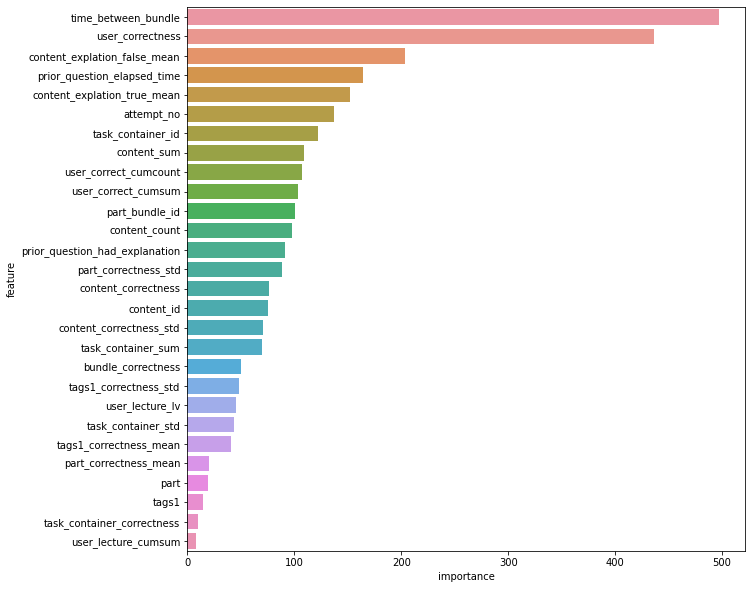

In [47]:
feature_importance = pd.DataFrame({
    'feature': train[features].columns.values.tolist(),
    'importance': model.feature_importance()
}).sort_values('importance', ascending=False)

fig, ax = plt.subplots(figsize=(10, 10))
sns.barplot(
    x=feature_importance.importance,
    y=feature_importance.feature,
    ax=ax,
);

In [51]:
export_model(model, 'lgbm.pickle')

In [52]:
def iter_test():
    for group_num, df in sample_test.groupby(by=['group_num']):
        yield df, group_num

In [53]:
def get_max_attempt(user_id, content_id):
    key = (user_id, content_id)

    if key in attempt_no_dict:
        attempt_no_dict[key] += 1
        return attempt_no_dict[key]

    attempt_no_dict[key] = 1
    return attempt_no_dict[key]

In [54]:
user_sum_dict = user_agg['sum'].astype('int16').to_dict(defaultdict(int))
user_count_dict = user_agg['count'].astype('int16').to_dict(defaultdict(int))
content_sum_dict = content_agg['sum'].astype('int32').to_dict(defaultdict(int))
content_count_dict = content_agg['count'].astype('int32').to_dict(defaultdict(int))
last_timestamp_dict = user_last_timestamp.astype('int64').to_dict(defaultdict(int))
attempt_no_dict = attempt_no_agg['sum'].to_dict(defaultdict(int))

In [56]:
%%time

prior_test = None
for test, _ in iter_test():

    # если есть предыдущая пачка вопросов, то обновим агрегаты/словари для вычисления новых фичей датасета
    if prior_test is not None:
        # извлечь ответы на предыдущую пачку вопросов
        prior_test['answered_correctly'] = eval(test['prior_group_answers_correct'].iloc[0])
        # исключить лекции
        prior_test = prior_test[prior_test['answered_correctly'] != -1].reset_index(drop = True)
        
        # обновим агрегаты 
        user_ids = prior_test['user_id'].values
        content_ids = prior_test['content_id'].values
        timestamps = prior_test['timestamp'].values
        targets = prior_test['answered_correctly'].values

        for user_id, content_id, timestamp, answered_correctly in zip(
            user_ids, content_ids, timestamps, targets
        ):
            user_sum_dict[user_id] += answered_correctly
            user_count_dict[user_id] += 1
            content_sum_dict[content_id] += answered_correctly
            content_count_dict[content_id] += 1

            # в рамках бандла вопросов одинаковый timestamp
            # в пачке тестовых данных только один бандлд для пользователя
            last_timestamp_dict[user_id] = timestamp
            
            # количество попыток ответить на вопрос для пользователя
            attempt_no_dict[(user_id, content_id)] += 1

    # прихранить пачку вопрсов для ее использования на следующей итерации
    prior_test = test.copy()
    
    # исключить лекции
    test = test[test['content_type_id'] != -1].reset_index(drop=True)
    
    # добавить в датасет вопросы
    test = pd.merge(
        test, questions, left_on='content_id', right_on='content_id', how='left')
    test['prior_question_had_explanation'] = test[
        'prior_question_had_explanation'].fillna(False).astype('bool')    
    
    # дефолтные зачения для новых фичей
    user_sum = np.zeros(len(test), dtype=np.int16)
    user_count = np.zeros(len(test), dtype=np.int16)
    content_sum = np.zeros(len(test), dtype=np.int32)
    content_count = np.zeros(len(test), dtype=np.int32)
    time_between_bundle = np.zeros(len(test), dtype=np.int32)

    user_ids = test['user_id'].values
    content_ids = test['content_id'].values
    timestamps = test['timestamp'].values
    
    for i, (user_id, content_id, timestamp) in enumerate(zip(user_ids, content_ids, timestamps)):
        user_sum[i] = user_sum_dict[user_id]
        user_count[i] = user_count_dict[user_id]
        content_sum[i] = content_sum_dict[content_id]
        content_count[i] = content_count_dict[content_id]
        time_between_bundle[i] = int(timestamp - last_timestamp_dict[user_id])
    
    # назначить новые фичи
    test['user_correctness'] = user_sum / user_count
    test['cumcount_answers'] = user_count
    test['user_uncorrect_count'] = user_count - user_sum
    test['content_count'] = content_count
    test['content_sum'] = content_sum
    test['content_correctness'] = content_sum / content_count
    test['time_between_bundle'] = time_between_bundle
    test["attempt_no"] = test[["user_id", "content_id"]].apply(
        lambda row: get_max_attempt(row["user_id"], row["content_id"]), axis=1)

    test['answered_correctly'] = model.predict(test[features])[:,1]
    

<timed exec>:63: RuntimeWarning: invalid value encountered in true_divide


KeyError: "['task_container_correctness', 'task_container_sum', 'task_container_std', 'user_correct_cumsum', 'user_lecture_lv', 'user_correct_cumcount', 'content_correctness_std', 'user_lecture_cumsum'] not in index"